In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm

from zmqRemoteApi import RemoteAPIClient

from utils import normalize, closedLoop
from elman_opt import ElmanNetwork, save, load

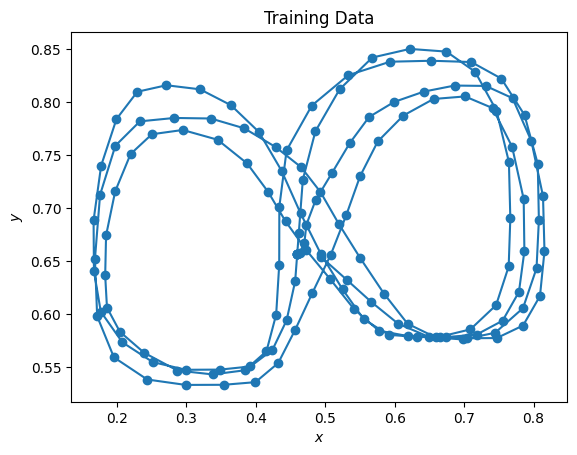

In [70]:
%matplotlib inline

data = np.load('data/figure8.npz')

dsFactor = 4

initialOffset = 200

xArr, xScale = normalize(data["positions"][initialOffset::dsFactor,0], returnFunc=True)
yArr, yScale = normalize(data["positions"][initialOffset::dsFactor,1], returnFunc=True)

xArr = xArr[:len(xArr)//4]
yArr = yArr[:len(yArr)//4]

plt.plot(xArr, yArr, '-o')
plt.title('Training Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [101]:
model = ElmanNetwork(inputDim=2,
                     contextDim=20,
                     outputDim=2,
                     optimizer='adam')

numEpochs = 5000

In [102]:
inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()


100%|█████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1369.26it/s]


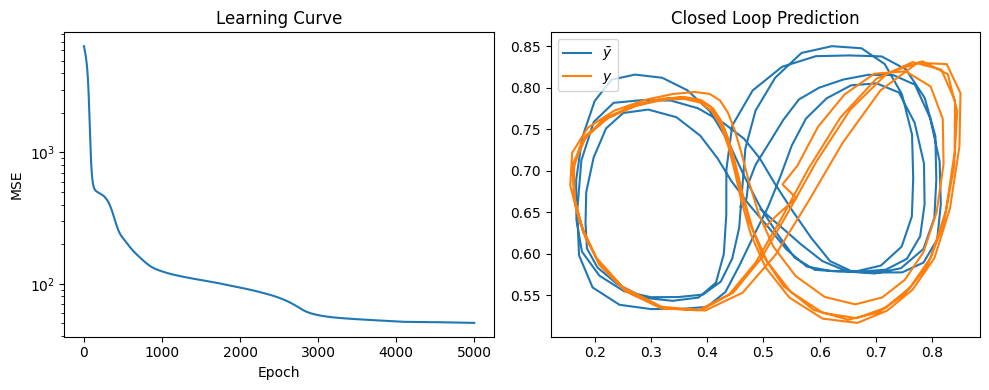

In [103]:
fig = plt.figure(figsize=(10,4))

ax = [None, None]
ax[0] = fig.add_subplot(1, 2, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 2, 2)

outputArr = model.predict(inputArr[0] + np.random.uniform(-.1, .1, size=2), len(inputArr)-1)

ax[1].set_title('Closed Loop Prediction')
ax[1].plot(targetArr[1:,0], targetArr[1:,1], label=r'$\bar y$')
ax[1].plot(outputArr[1:,0], outputArr[1:,1], label=r'$y$')
ax[1].legend()

fig.tight_layout()

#plt.savefig('images/circle_training.png')
plt.show()

## Training Debugging

100%|███████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1322.53it/s]


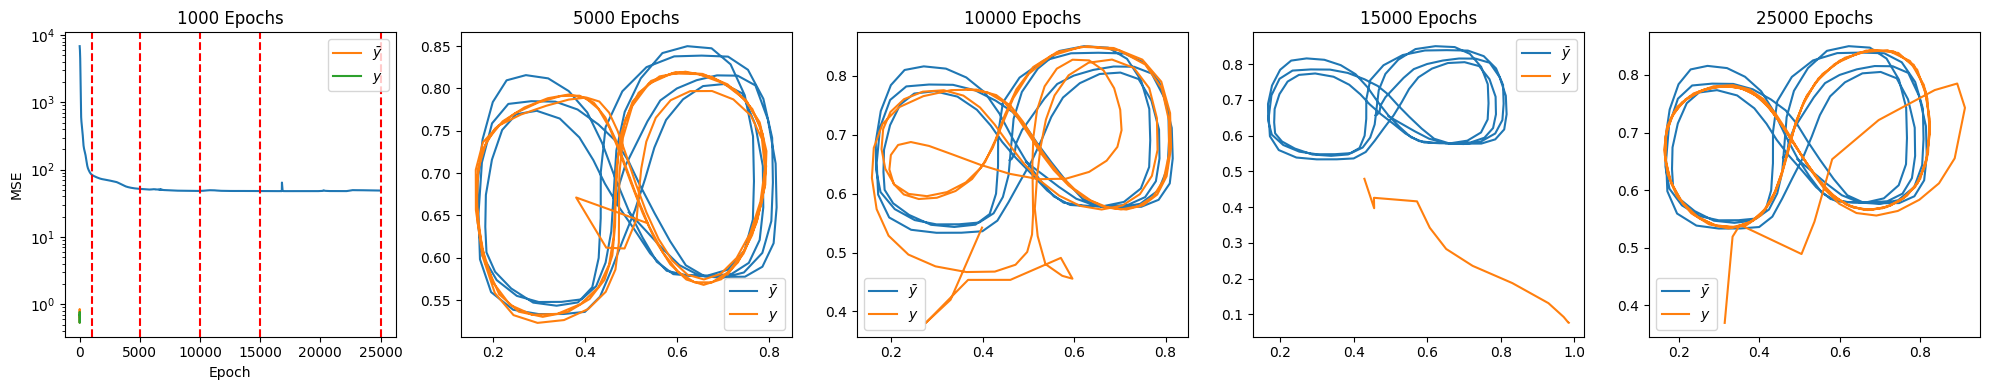

In [98]:
%matplotlib inline

epochArr = np.array([1000, 5000, 10000, 15000, 25000])
epochDiffs = np.append(epochArr[0], epochArr[1:] - epochArr[:-1])

inputArr = np.array(list(zip(xArr, yArr)))[:-1]
targetArr = np.array(list(zip(xArr, yArr)))[1:]

model = ElmanNetwork(inputDim=2,
                     contextDim=20,
                     outputDim=2,
                     optimizer='adam')

allOutputArr = []
errorArr = []

for numEpochs in epochDiffs:
    
    for epoch in tqdm.tqdm(range(numEpochs)):
        # Context and output
        contextArr, outputArr = model.forwardSequence(inputArr)
        err  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
        errorArr.append(err)
        model.updateParameters()
        
    outputArr = model.predict(inputArr[0,0] + np.random.uniform(-.1, .1, size=2), len(inputArr)-1)

    allOutputArr.append(outputArr)
    
fig, ax = plt.subplots(1, len(allOutputArr), figsize=(len(allOutputArr)*3+5,4))

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

for i in range(len(allOutputArr)):
    ax[i].set_title('Closed Loop Prediction')
    ax[i].plot(targetArr[1:,0], targetArr[1:,1], label=r'$\bar y$')
    ax[i].plot(allOutputArr[i][1:,0], allOutputArr[i][1:,1], label=r'$y$')
    ax[i].legend()
    ax[i].set_title(f'{epochArr[i]} Epochs')
    ax[0].axvline(epochArr[i], c='r', linestyle='--')

fig.tight_layout()

#plt.savefig('images/circle_training.png')
plt.show()

In [76]:
#open connection to CoppeliaSim, must be running
client = RemoteAPIClient()
sim = client.getObject('sim')

#open scene in the simulator:
import os 
dir_path = os.getcwd()

sim.loadScene(dir_path+'/torobo.ttt')

#we will use synchronous mode, client.step() will perform one simulation step
#otherwise the simulator runs freely, e.g. time can pass between mutliple simulator calls:
#e.g. sending commands to multiple joints may happen at different times
client.setStepping(True)

In [77]:
#Read object ids from scene
hands = [sim.getObject('./tip_left'), sim.getObject('./tip_right')]
rightShoulderJoints = [sim.getObject('./right_arm_joint_1'), sim.getObject('./right_arm_joint_2')]

In [104]:
sim.startSimulation()
# The wrists are bent to start, so let's straighten them out
sim.setJointTargetPosition(sim.getObject('./right_arm_joint_6'), 0)
sim.setJointTargetPosition(sim.getObject('./left_arm_joint_6'), 0)

nSteps = 300

handPos = np.zeros((2,nSteps,3))
tArr = np.zeros(nSteps)

predictArr = model.predict(inputArr[0,0], nSteps)
predictArr = np.array(list(zip(xScale(predictArr[:,0]), yScale(predictArr[:,1]))))

for i in tqdm.tqdm(range(nSteps)):
    
    sim.setJointTargetPosition(rightShoulderJoints[0], predictArr[i,0])
    sim.setJointTargetPosition(rightShoulderJoints[1], predictArr[i,1])

    # Read the positions of the hands
    for j in range(2):
        handPos[j,i] = sim.getObjectPosition(hands[j], sim.handle_world)
        
    #next time step ... 
    client.step()
    tArr[i] = sim.getSimulationTime()
    
sim.stopSimulation()

100%|█████████████████████████████████████████████████████████| 300/300 [01:00<00:00,  4.92it/s]


1

In [105]:
%matplotlib qt

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')

#ax.scatter(handPos[0,:,0], handPos[0,:,1], handPos[0,:,2], label='Left')
ax.scatter(handPos[1,:,0], handPos[1,:,1], handPos[1,:,2], label='Right')
ax.set_title('Hand Positions')
#ax.set_xlabel('Time [s]')?
ax.legend()

ax2 = fig.add_subplot(1, 2, 2)

ax2.plot(predictArr[:,0], predictArr[:,1])
ax2.set_xlabel('Joint 1 angle')
ax2.set_ylabel('Joint 2 angle')

fig.tight_layout()
plt.show()

In [29]:
sim.stopSimulation()

1